### Base Florance-2 Model

This notebook serves as an intro to Florance 2 base performance and shows some examples of the types of tasks it can acomplish.

Florance-2 is a vision foundation model trained by Microsoft in 2023. It has good out of the box performance at a variety of image tasks. It produces predictions by outputing text tokens, with a limit of 1024 per image. To designate parts of the image, normalised x, y co-ordinates are produced by the model.

This notebook details how to use the Florance-2 base model. We need to specify both a task type and a specific prompt for further instructions.

Task Types (a sample of the main tasks), input as a prompt:
- `<CAPTION>` Description
- `<DETAILED_CAPTION>` Description
- `<OD>` Object detection
- `<REFERRING_EXPRESSION_SEGMENTATION>` Segmentation, given text
- `<REGION_TO_SEGMENTATION>` Segmentation, given a bounding box
- `<OCR>` Optical Character Recognition
- `<OCR_WITH_REGION>` Optical Character Recognition which also provides a bounding box

We can also add regions by specifying additional text after the task type above (if type <REGION_TO_.....>), ie `<TASK><loc1><loc2><loc3><loc4>`.

Alternative:
- VQA: What does the image describe?
- VQA: What does the region `<loc1><loc2><loc3><loc4>` describe?
- Object Detection: Locate objects in the image.
- Object Detection: Locate the phrases in the caption: `<loc1><loc2><loc3><loc4>`.
- Segmentation: What is the polygon mask of region `<loc1><loc2><loc3><loc4>`?
- OCR: Extract text with region `<loc1><loc2><loc3><loc4>`.

Additional reading:
- https://arxiv.org/abs/2311.06242
- https://medium.com/data-science/Florance-2-mastering-multiple-vision-tasks-with-a-single-vlm-model-435d251976d0

#### Setup model and import libraries

In [ ]:
# import libraries
import os
import numpy as np
import torch
from transformers import AutoProcessor, AutoModelForCausalLM 

# import custom libraries
from utils.image_functions import read_image, display_image
from utils.florence_functions import draw_bounding_boxes, inference_florance

# setup device and dtype if using GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {device} \nTORCH DTYPE: {torch_dtype}")

# Load model and processor from Hugging Face
# microsoft/Florance-2-large-ft is the fine-tuned version of microsoft/Florance-2-large. It is finetuned for a variety of downstream tasks.
model_name = "microsoft/Florence-2-large-ft" # microsoft/Florance-2-large
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
florance2_setup = [model, processor, device, torch_dtype]

# setup correct file paths
data_path = "./sample_data/01-Base_Model/"

DEVICE: cuda:0 
TORCH DTYPE: torch.float16


#### Caption
Describe an image

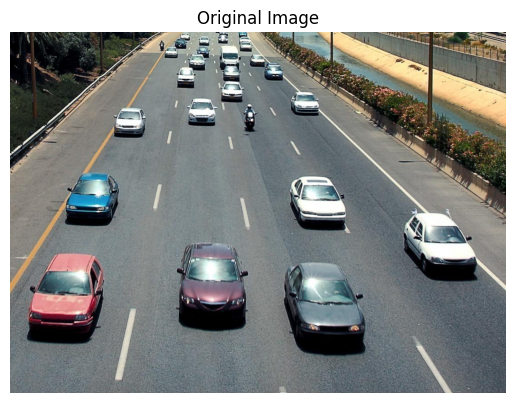

Prompts: ['<CAPTION>']
['A highway filled with lots of traffic next to a river.'] 

Prompts: ['<MORE_DETAILED_CAPTION>']
['There are several cars driving on the street. There is a blue car in the middle of the street and a red car in front of it. There are white lines on the road. '] 

Prompts: ['<REGION_TO_CATEGORY><loc_200><loc_200><loc_290><loc_300>']
['car']


In [13]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

# <CAPTION> <DETAILED_CAPTION> <MORE_DETAILED_CAPTION>
task_input = "<CAPTION>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print(combined_results, "\n")

task_input = "<MORE_DETAILED_CAPTION>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print(combined_results, "\n")

# provided bbox coordinates correlate to a car in top left of image. Lets see if Florance-2 can detect and classify it.
task_input = "<REGION_TO_CATEGORY>" # <REGION_TO_DESCRIPTION>
text_inputs = ["<loc_200><loc_200><loc_290><loc_300>"] # Normalised x1, x2, y1, y2 for florance-2 model. Range is [001, 999]
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print([result.split("<")[0] for result in combined_results])

#### Object Detection
Find objects in an image

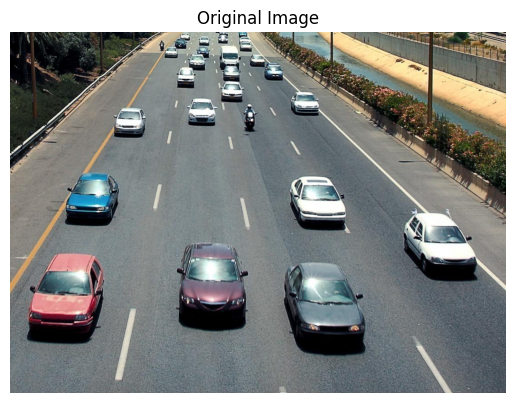

Prompts: ['<OD>']


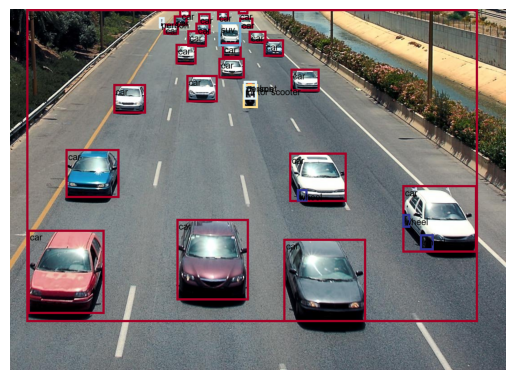

Prompts: ['<OPEN_VOCABULARY_DETECTION>car', '<OPEN_VOCABULARY_DETECTION>van']


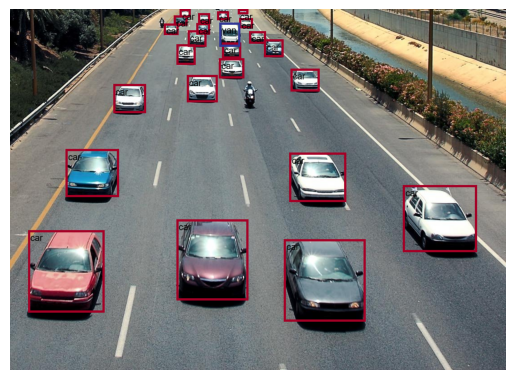

In [14]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

# no classes/ prompts specified
task_input = "<OD>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)  # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5) # draw bounding boxes on image

# three classes/ prompts - better performance with enhanced prompt
task_input = "<OPEN_VOCABULARY_DETECTION>"
text_inputs = ["car", "van"]
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["bboxes_labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5)

### Optical Character Recognition
Extract text from an image

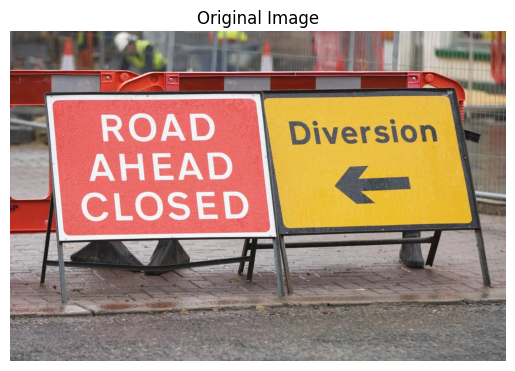

Prompts: ['<OCR>']
[{'<OCR>': 'ROADDiversionAHEADCLOSED'}] 

Prompts: ['<OCR_WITH_REGION>']


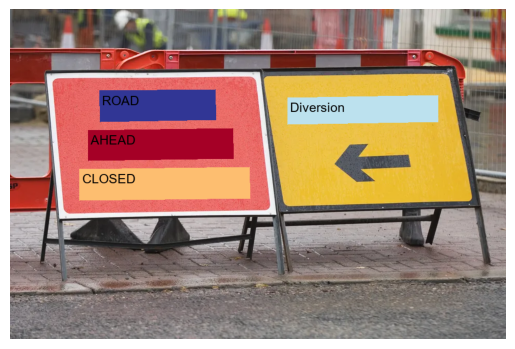

In [15]:
# base image
img_path = os.path.join(data_path, "base_ocr.jpg")
img = read_image(img_path)
display_image(img, "Original Image")

task_input = "<OCR>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
print(results, "\n")

task_input = "<OCR_WITH_REGION>" # returns text with bounding boxes
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box for result in results for box in result[task_input]["quad_boxes"]], "labels": [label.replace("</s>", "").replace("<s>", "") for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25)

#### Segmentation
Label each pixel of a classs in an image. Note: one object segmented for each image, a quick fix for this below.

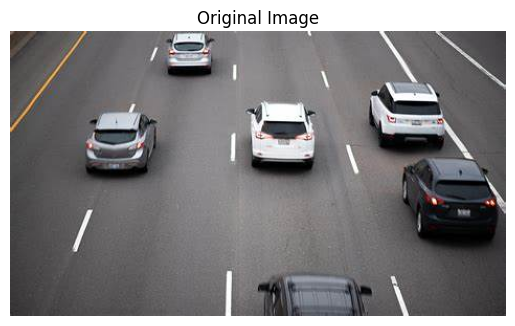

Prompts: ['<REFERRING_EXPRESSION_SEGMENTATION>cars']


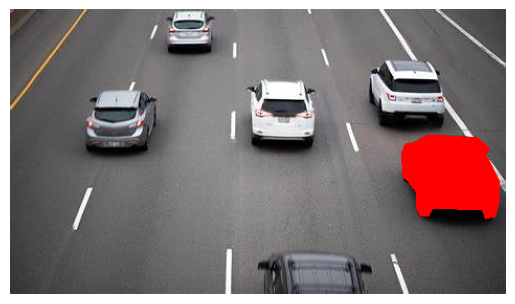

In [16]:
# base image
img_path = os.path.join(data_path, "base_segmentation.png")
img = read_image(img_path)
display_image(img, "Original Image")

task_input = "<REFERRING_EXPRESSION_SEGMENTATION>" # returns text with bounding boxes
text_inputs = ["cars"]
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box[task_input]['polygons'][0][0] for box in results], "labels": [box[task_input]['labels'] for box in results]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)

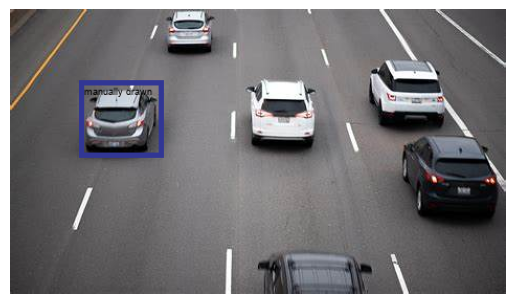

In [17]:
# we can also provide a bounding box to the model to get the segmentation of the object in the bounding box
# Use this function to decide the normalised bounding box on the image

normalized_bboxes = [ # select one region for now
    [0.14, 0.25, 0.31, 0.52]
]
width, height = img.size
absolute_bboxes = [(x1 * width, y1 * height, x2 * width, y2 * height) for x1, y1, x2, y2 in normalized_bboxes]
combined_results = {"bboxes": absolute_bboxes, "labels": ["manually drawn" for i in absolute_bboxes]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=9)

Prompts: ['<REGION_TO_SEGMENTATION><loc_140><loc_250><loc_310><loc_520>']


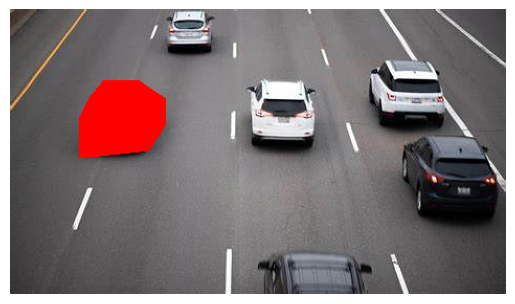

In [18]:
# # <REGION_TO_SEGMENTATION>
florance_bbox = "".join([f"<loc_{int(min(i,1)*1000)}>" for bbox in normalized_bboxes for i in bbox]) # format as so: '<loc_335><loc_412><loc_653><loc_832>' - 0.653 is equal to loc_693 as florance cordinates are between 0-999

task_input = "<REGION_TO_SEGMENTATION>" # returns text with bounding boxes
text_inputs = [florance_bbox] # add the bounding box to the text inputs
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box[task_input]['polygons'][0][0] for box in results], "labels": [box[task_input]['labels'] for box in results]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)

### Object Detection + Segmentaion to label all instances.

Unfortunately, the Florance model does not support segmentation for multiple objects in the same image, and even if it did we would quickly come up against the maximum token generation for the model: 1024. This is a limitation. However, there is an easy way to get around this, demonstrated below.

We will combine OD and segmentation below, or you can manually label each car yourself using the above function so Florance can segment it.

Prompts: ['<OPEN_VOCABULARY_DETECTION>cars']


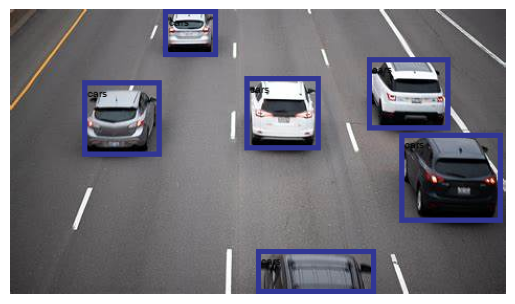

In [19]:
# three classes/ prompts - better performance with enhanced prompt
task_input = "<OPEN_VOCABULARY_DETECTION>"
text_inputs = ["cars"]
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["bboxes_labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=10)

Prompts: ['<REGION_TO_SEGMENTATION><loc_785><loc_435><loc_992><loc_748>']
Prompts: ['<REGION_TO_SEGMENTATION><loc_719><loc_169><loc_886><loc_423>']
Prompts: ['<REGION_TO_SEGMENTATION><loc_146><loc_253><loc_305><loc_516>']
Prompts: ['<REGION_TO_SEGMENTATION><loc_473><loc_237><loc_625><loc_495>']
Prompts: ['<REGION_TO_SEGMENTATION><loc_496><loc_842><loc_737><loc_998>']
Prompts: ['<REGION_TO_SEGMENTATION><loc_309><loc_3><loc_418><loc_166>']


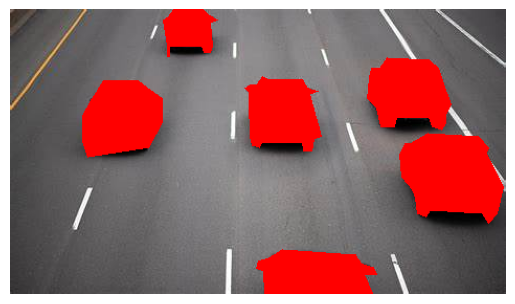

In [20]:
all_polygons = []
all_labels = combined_results["labels"]

# # <REGION_TO_SEGMENTATION>
adj_flo_list = ["".join([f"<loc_{int(min(loc,1)*1000)}>" for loc in list(np.array(od_bbox) / np.array([img.size[0], img.size[1], img.size[0], img.size[1]]))]) for od_bbox in combined_results['bboxes']]
task_input = "<REGION_TO_SEGMENTATION>" # returns text with bounding boxes
for idx, florance_bbox in enumerate(adj_flo_list):
    text_inputs = [florance_bbox] # add the bounding box to the text inputs
    results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
    all_polygons.append(results[0][task_input]['polygons'][0][0])
    
combined_results = {"polygons": all_polygons, "labels": all_labels}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)